# HuggingFace LongFormer with NER
## Feedback Prize - Evaluating Student Writing

* longformer-base-4096 ([docs][1] and [specs][2])
* NER formulation
* 10% validation set

Similar to Roberta but accepts inputs as long as 4096 tokens. This notebook uses only 1024 tokens. 

[1]: https://huggingface.co/docs/transformers/model_doc/longformer
[2]: https://huggingface.co/allenai/longformer-base-4096

# NER
Create new NER tokens or load existing tokens. 

In [20]:
from pathlib import Path
import os

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme('notebook')
sns.set_style('darkgrid')

from tqdm import tqdm
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 5

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModel

In [28]:
NOTEBOOK_DIR = Path('.').cwd().resolve().absolute()
KAGGLE_DIR = Path('../../kaggle').expanduser().resolve().absolute()
COMPETITION_DIR = KAGGLE_DIR / 'feedback-prize-2021'
INPUT_DIR = COMPETITION_DIR / 'input'
INPUT_DIR.mkdir(exist_ok=True)
WORKING_DIR = COMPETITION_DIR / 'working'
WORKING_DIR.mkdir(exist_ok=True)
print(NOTEBOOK_DIR)
print(WORKING_DIR)
assert WORKING_DIR == NOTEBOOK_DIR

/home/hobs/code/tangibleai/experiments/feedback-prize-2021/kaggle/feedback-prize-2021
/home/hobs/code/tangibleai/experiments/feedback-prize-2021/kaggle/feedback-prize-2021/working


AssertionError: 

PosixPath('/home/hobs/code/tangibleai/experiments/feedback-prize-2021/kaggle')

In [23]:
COMPETITION_DIR = Path('./feedback-prize-2021')
COMPETITION_DIR.mkdir(exist_ok=True)
os.chdir(COMPETITION_DIR)
COMPETITION_DIR.cwd()

PosixPath('/home/hobs/code/tangibleai/experiments/feedback-prize-2021/kaggle/feedback-prize-2021')

In [ ]:

WORKING_DIR.mkdir(exist_ok=True)
os.chdir(WORKING_DIR)
COMPETITION_DIR.cwd()

In [6]:
DATA_DIR = Path('../input/feedback-prize-2021')
MODEL_ORG = 'allenai'
MODEL_NAME = 'longformer-base-4096'
MODEL_DIR = Path('/kaggle/working') / MODEL_NAME
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True) 

In [7]:
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModel.from_pretrained(MODEL_DIR)
    print(f'Load model and tokenizer from {MODEL_DIR}')
except (OSError, ValueError):
    huggingface_name = MODEL_ORG + '/' + MODEL_NAME
    print(f'Attempting to download model and tokenizer from huggingface: {huggingface_name} ...')
    tokenizer = AutoTokenizer.from_pretrained(huggingface_name)
    tokenizer.save_pretrained(MODEL_DIR)
    model = AutoModel.from_pretrained(huggingface_name)
    model.save_pretrained(MODEL_DIR)
    print(f'Saved model and tokenizer in {MODEL_DIR}')

file /kaggle/working/longformer-base-4096/config.json not found


Attempting to download model and tokenizer from huggingface: allenai/longformer-base-4096 ...


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saved model and tokenizer in /kaggle/working/longformer-base-4096


# Offline?
Download:

1. model weights
2. tokenizer files
3. config file

and upload these to a Kaggle dataset.

#### Load training set

In [10]:
# kaggle competitions download -c feedback-prize-2021 /kaggle/input

train = pd.read_csv(DATA_DIR / 'train.csv')
print( train.shape )
train.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/feedback-prize-2021/train.csv'

In [9]:
print('Training labels:')
train.discourse_type.unique()

Training labels:


NameError: name 'train' is not defined

In [10]:
ids = train.id.unique()
print(f'{len(ids)} training set texts.')

15594 training set texts.


# Tokenize Train
The following code converts Kaggle's train dataset into a NER token array that we can use to train a NER transformer. I have made it very clear which targets belong to which class. This allows us to very easily convert this code to `Question Answer formulation` if we want. Just change the 14 NER arrays to be 14 arrays of `start position` and `end position` for each of the 7 classes. (You will need to think creatively what to do if a single text has multiple of one class).

In [12]:
MAX_LEN = 1024

shape = (len(ids), MAX_LEN)
train_tokens = np.zeros(shape, dtype='int32')
train_attention = np.zeros(shape, dtype='int32')

# HELPER VARIABLES
train_lens = []
target_map = ['Lead',        'Position',      'Evidence',      'Claim',         'Concluding Statement', 'Counterclaim',  'Rebuttal']
targets_b = [np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),        np.zeros(shape), np.zeros(shape)]
targets_i = [np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),        np.zeros(shape), np.zeros(shape)]


In [ ]:
# all discourse_start indexes without each document id are sorted in increasing order so the diff is never negative
assert not (train.groupby('id')['discourse_start'].diff() <= 0).sum()

In [13]:


for id_num in range(len(ids)):
    if LOAD_TOKENS_FROM: break
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = IDS[id_num]
    name = f'data/train/{n}.txt'
    txt = open(name, 'r').read()
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids']
    train_attention[id_num,] = tokens['attention_mask']
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets = tokens['offset_mapping']
    offset_index = 0
    df = train.loc[train.id==n]
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        if offset_index>len(offsets)-1:
            break
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        beginning = True
        while b>c:
            if (c>=a)&(b>=d):
                k = target_map[row.discourse_type]
                if beginning:
                    targets_b[k][id_num][offset_index] = 1
                    beginning = False
                else:
                    targets_i[k][id_num][offset_index] = 1
            offset_index += 1
            if offset_index>len(offsets)-1:
                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]
    if not id_num % 100:
        print(f'{id_num} {end}')

NameError: name 'LOAD_TOKENS_FROM' is not defined

In [18]:
if LOAD_TOKENS_FROM is None:
    plt.hist(train_lens,bins=100)
    plt.grid.('on')
    plt.show()

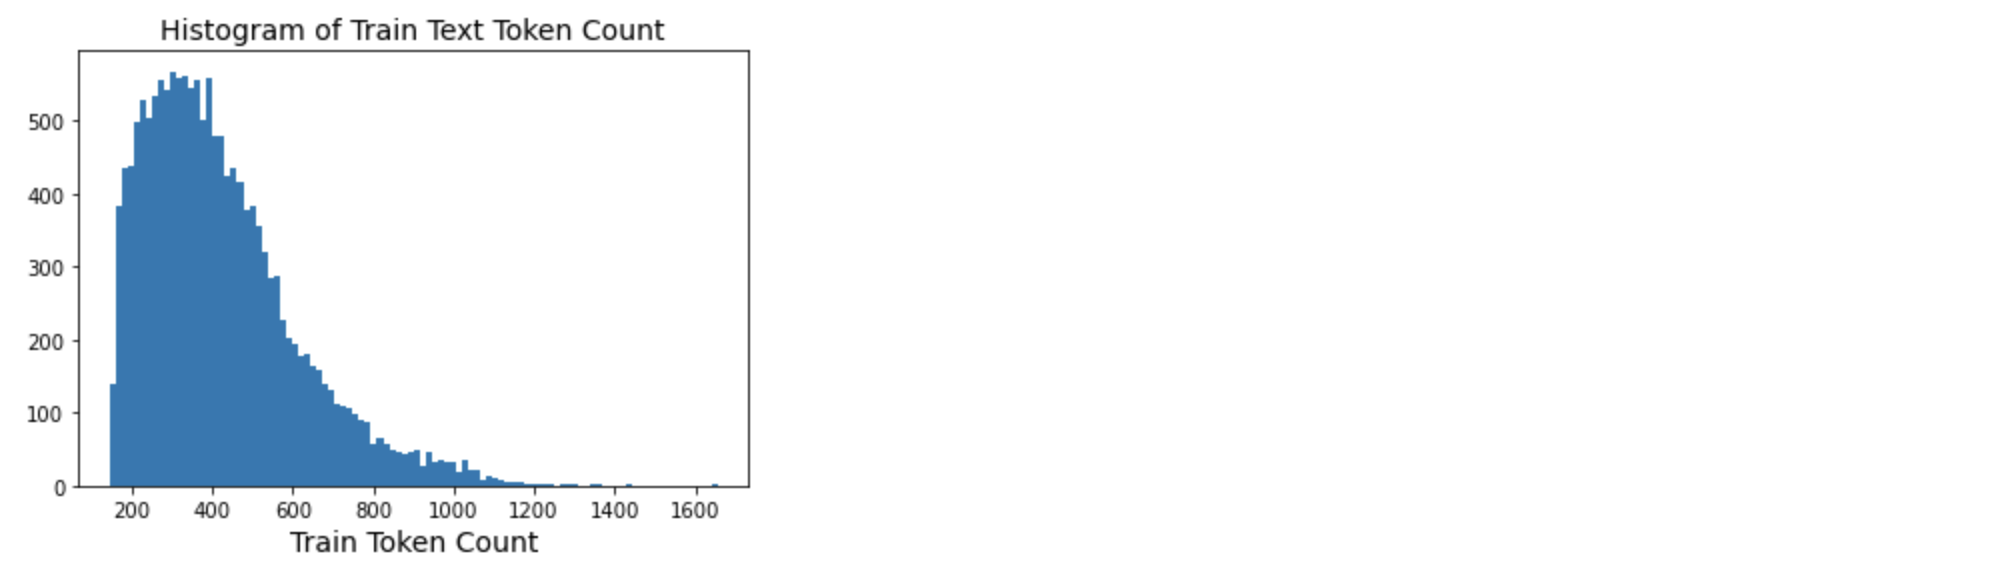

From the histogram of train token counts above, we see that using a transformer width of 1024 is a good comprise of capturing most of the data's signal but not having too large a model. We could probably explore other widths between 512 and 1024 also. Or we could use widths of size 512 or smaller and use a stride which breaks a single text into multiple chunks (with possible overlap).

In [19]:
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
    for k in range(7):
        targets[:,:,2*k] = targets_b[k]
        targets[:,:,2*k+1] = targets_i[k]
    targets[:,:,14] = 1-np.max(targets,axis=-1)

In [35]:
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_LEN}', targets)
    np.save(f'tokens_{MAX_LEN}', train_tokens)
    np.save(f'attention_{MAX_LEN}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_LEN}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_LEN}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_LEN}.npy')
    print('Loaded NER tokens')

FileNotFoundError: [Errno 2] No such file or directory: '../input/tf-longformer-v12/targets_1024.npy'

# Train or Load Model
If you provide a path in variable `LOAD_MODEL_FROM` above, then it will load your previously trained model. Otherwise it will train now. 

We train 5 epochs of batch size 32 using learning rate `1e4` for the first four and `1e5` for the last epoch. I trained my model offline. If you wish to train on Kaggle's GPU, we may need to reduce the batch size. If we reduce the batch size to 8. That is 1/4 original. So we should also reduce the learning rates to `0.25e-4` and `0.25e-5`.

In [ ]:
# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))

In [ ]:
# LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 5
LRS = [1e-4, 1e-4, 1e-4, 1e-4, 1e-5]
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
# LOAD MODEL
if LOAD_MODEL_FROM:
    model.load_weights(f'{LOAD_MODEL_FROM}/long_v{VER}.h5')
    
# OR TRAIN MODEL
else:
    model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
          y = targets[train_idx,],
          validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                             targets[valid_idx,]),
          callbacks = [lr_callback],
          epochs = EPOCHS,
          batch_size = 32,
          verbose = 2)

    # SAVE MODEL WEIGHTS
    model.save_weights(f'long_v{VER}.h5')

# Validate Model - Infer OOF
We will now make predictions on the validation texts. Our model makes label predictions for each token, we need to convert this into a list of word indices for each label. Note that the tokens and words are not the same. A single word may be broken into multiple tokens. Therefore we need to first create a map to change token indices to word indices.

In [ ]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
print('OOF predictions shape:',p.shape)
oof_preds = np.argmax(p,axis=-1)

In [ ]:
target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}

In [ ]:
def get_preds(dataset='train', verbose=True, text_ids=IDS[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
    
        # GET ID
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
    
        # GET TOKEN POSITIONS IN CHARS
        name = f'../input/feedback-prize-2021/{dataset}/{n}.txt'
        txt = open(name, 'r').read()
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
    
        # GET WORD POSITIONS IN CHARS
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n'):
                blank=True
        w.append(1e6)
            
        # MAPPING FROM TOKENS TO WORDS
        word_map = -1 * np.ones(MAX_LEN,dtype='int32')
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        
        # CONVERT TOKEN PREDICTIONS INTO WORD LABELS
        # KEY:
        # 0: LEAD_B, 1: LEAD_I
        # 2: POSITION_B, 3: POSITION_I
        # 4: EVIDENCE_B, 5: EVIDENCE_I
        # 6: CLAIM_B, 7: CLAIM_I
        # 8: CONCLUSION_B, 9: CONCLUSION_I
        # 10: COUNTERCLAIM_B, 11: COUNTERCLAIM_I
        # 12: REBUTTAL_B, 13: REBUTTAL_I
        # 14: NOTHING i.e. O
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_LEN:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_LEN: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_LEN: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    # MAKE DATAFRAME
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    
    return df

In [ ]:
oof = get_preds( dataset='train', verbose=True, text_ids=IDS[valid_idx] )
oof.head()

In [ ]:
print('The following classes are present in oof preds:')
oof['class'].unique()

# Compute Validation Metric
The following code is from Rob Mulla's excellent notebook [here][2]. Our LongFormer single fold model achieves CV score 0.617! Hooray!

[2]: https://www.kaggle.com/robikscube/student-writing-competition-twitch

In [ ]:
# CODE FROM : Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [ ]:
# VALID DATAFRAME
valid = train.loc[train['id'].isin(IDS[valid_idx])]

In [ ]:
f1s = []
CLASSES = oof['class'].unique()
for c in CLASSES:
    pred_df = oof.loc[oof['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

# Infer Test Data
We will now infer the test data and create a submission. Our CV is 0.617, let's see what our LB is!

In [ ]:
# GET TEST TEXT IDS
files = os.listdir('../input/feedback-prize-2021/test')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
print('There are',len(TEST_IDS),'test texts.')

In [ ]:
# CONVERT TEST TEXT TO TOKENS
test_tokens = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'../input/feedback-prize-2021/test/{n}.txt'
    txt = open(name, 'r').read()
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [ ]:
# INFER TEST TEXTS
p = model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)
print('Test predictions shape:',p.shape)
test_preds = np.argmax(p,axis=-1)

# Write Submission CSV

In [ ]:
# GET TEST PREDICIONS
sub = get_preds( dataset='test', verbose=False, text_ids=TEST_IDS, preds=test_preds )
sub.head()

In [ ]:
# WRITE SUBMISSION CSV
sub.to_csv('submission.csv',index=False)